In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots

  Activating environment at `~/Documents/CMU-Projects/MRSD/Sem2/OCRL/Project/Project.toml`
Precompiling project...
  ✓ WebIO
  ✓ JSExpr
  ✓ Blink
  ✓ MeshCat
  ✓ MathOptInterface
  ✓ Plots
  ✓ ECOS
  ✓ Convex
  ✓ Ipopt
  9 dependencies successfully precompiled in 44 seconds (184 already precompiled)
[ Info: Precompiling Convex [f65535da-76fb-5f13-bab9-19810c17039a]
[ Info: Precompiling ECOS [e2685f51-7e38-5353-a97d-a921fd2c8199]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]


In [3]:
function dynamics(x::Vector, u)
    
    # differential drive robot dynamics (in plane)
    
   return u[1]*[cos(x[3]);sin(x[3]);0] + u[2]*[0;0;1]

end

function rk4(x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(x, u)
    k2 = dt*dynamics(x + k1/2, u)
    k3 = dt*dynamics(x + k2/2, u)
    k4 = dt*dynamics(x + k3, u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

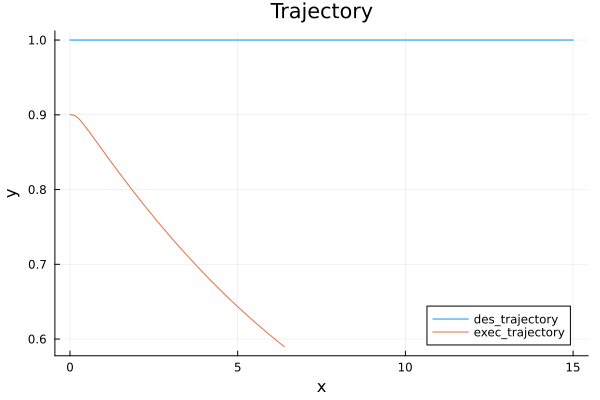

In [4]:
function ϕ(x)
    p = x[1:2]  
    -(norm(p - [3,3])^2 - 1.5^2) 
end
function ∇ϕ(x)
    ForwardDiff.gradient(ϕ, x)
end
function cbf(x::Vector,  # current state 
             u0::Vector, # nominal control input 
             A::Matrix,  # discrete time A 
             B::Matrix,  # discrete time B 
             dt::Real)   # time step size 
    
    # tune this (lower the number = more aggressive)
    λ = -5
    
    # our variable we are solving for 
    u = cvx.Variable(2)
    
    # let's approximate xdot with a difference between (x_{k+1} - x_k)/dt
    # this is because if we just did the continuous time dynamics, ϕdot would 
    # be zero. This is because if x = [p;v], dϕ/dx = [dϕ/dp; 0] since it only depends on 
    # the position, not velocity. our continous time dynamics are xdot = [v;u], meaning when
    # we take ∇ϕ'ẋ, we get [dϕ/dp; 0]'[v;u], which is not a function of u. This is because u
    # cannot directly affect ṗ. If instead we average xdot over a time step, u can now affect
    # ṗ, and everything works out. 
    xdot = ((A*x + B*u) - x)/dt
    gradient = ∇ϕ(x)
    ϕdot = transpose(gradient)*xdot 

    # find the closest control to the given u0
    prob = cvx.minimize(cvx.sumsquares(u - u0))
    
    # must be safe
    prob.constraints += [ϕdot <= λ*ϕ(x)]
    
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)
    
    return vec(u.value)
end
function circle()
    center = [3,3]
    rad = 1.5 
    θs = range(0,2*pi,length = 100)
    points = [(rad*[cos(θ),sin(θ)]+center) for θ in θs]
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    x, y
end
    
let 
    
    # robot dynamics 
    dt = 0.01
    tf = 8.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    xtraj = [zeros(3) for i=1:N]
    xtraj[N] = [15,1,0]
    xgoal = [15,1,0]
    
    for i=1:N-1
        xtraj[i][2] = 1
        xtraj[i][1] = xtraj[N][1]*((i-1)/N)
    end
    
    utraj = [zeros(2) for i=1:N-1]
    
    for i=1:N-1
        utraj[i][1] = (xtraj[i+1][1]-xtraj[i][1])/tf
    end
    
    X = [zeros(3) for i = 1:N]
    X[1] = [0,0.9,0] #initial condition
    X[2] = [0,0.9,0] #initial condition
    
    u = [0,0]
    
#     # simple PD controller
#     kp = 2.0; kd = 2.0 
#     K = [kp*I(2)  kd*I(2)]
    
    # P controller 
    kp = 0.1
    kd = 0.3
    
    prev_x_err = 0
    prev_y_err = 0
    prev_yaw_err = 0
    

    # sim 
    for i = 1:(N-1)
#         @show x_err = xgoal[1]-X[i][1]
#         @show y_err = xgoal[2]-X[i][2]
        x_err = xtraj[i][1]-X[i][1]
        y_err = xtraj[i][2]-X[i][2]
#         yaw_err = xgoal[i][3]-X[i][3]
        yaw_err = atan(y_err/x_err)
        
        x_d = (x_err-prev_x_err)/dt
        y_d = (y_err-prev_y_err)/dt
        yaw_d = (yaw_err-prev_yaw_err)/dt
        
        vx = kp*norm([x_err, y_err]) + kd*norm([x_d, y_d])
        vx = clamp(vx,0,3)
        ω = kp*yaw_err + kd*yaw_d
        ω = clamp(ω,-0.1,0.1)
        
        u = [vx; ω]

        A = FD.jacobian(dx -> rk4(dx,u,dt), xtraj[i])
        B = FD.jacobian(du -> rk4(X[i],du,dt), utraj[i])
#         u = cbf(X[i],u0,A,B,dt) # modified safe control 
        
        X[i+1] = rk4(X[i],u,dt)
        
        prev_x_err = x_err
        prev_y_err = y_err
        prev_yaw_err = yaw_err
        
    end
    
    Xm = hcat(X...)
#     @show Xm[3,:]
    X_traj = hcat(xtraj...)
    x, y = circle()
#     plot(x,y,lc = :red, ls = :dash,label = "obstacle")
    plot(X_traj[1,:], X_traj[2,:], label  = "des_trajectory", xlabel = "x", ylabel = "y", title = "Trajectory")
    plot!(Xm[1,:],Xm[2,:], label  = "exec_trajectory", xlabel = "x", ylabel = "y", title = "Trajectory")
    
#     ϕs = ϕ.(X)
#     plot(t_vec,ϕs,label = "",xlabel = "time (s)", ylabel = "ϕ", title = "Safety Index ϕ(x)")
    
end